In [1]:
%matplotlib inline
import os
import cv2
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np

### Measuring pixel/distance
**Problem**
- Want to have a constant `pixel/distance` for moving Astrobee/camera with pixel diffrence

**Solution**
1. Take a picture that have AR TAG at vary position from original positions
2. Compute the distance from original of each corners for each directions of movement
3. Average it?

Using this code running in local simulator
```java
private void moveAndTakePic(Point p, Quaternion q, String text) {
    // some Astrobee moving shit
    for (int i = 0; i < 3; i++) {
        api.moveTo(p, q, false);
    }

    // wait a little bit for Astrobee to finished moving?
    try {
        Thread.sleep(100);
    }
    catch (Exception e) {};
    api.saveMatImage(api.getMatNavCam(), text);
}


@Override
protected void runPlan1(){
    api.startMission();
    // move to point A
    Point point = new Point(10.71f, -7.5f, 4.48f);
    Quaternion quaternion = new Quaternion((0f, 0.707f, 0f, 0.707f);

    // take origin pic
    moveAndTakePic(point, quaternion, "origin");

    float d1 = 0.2f;
    float d2 = 0.4f;

    // larger_x1
    point = new Point(10.71f + d1, -7.7f, 4.48f);
    moveAndTakePic(point, quaternion, "larger_x1");

    // larger_x2
    point = new Point(10.71f + d2, -7.5f, 4.48f);
    moveAndTakePic(point, quaternion, "larger_x2");

    // smaller_x1
    point = new Point(10.71f - d1, -7.5f, 4.48f);
    moveAndTakePic(point, quaternion, "smaller_x1");

    // smaller_x2
    point = new Point(10.71f - d2, -7.5f, 4.48f);
    moveAndTakePic(point, quaternion, "smaller_x2");

    // larger_y1
    point = new Point(10.71f, -7.5f + d1, 4.48f);
    moveAndTakePic(point, quaternion, "larger_y1");

    // larger_y2
    point = new Point(10.71f, -7.5f + d2, 4.48f);
    moveAndTakePic(point, quaternion, "larger_y2");

    // smaller_y1
    point = new Point(10.71f, -7.5f - d1, 4.48f);
    moveAndTakePic(point, quaternion, "smaller_y1");

    // smaller_y2
    point = new Point(10.71f, -7.5f - d2, 4.48f);
    moveAndTakePic(point, quaternion, "smaller_y2");

}
```

In [2]:
# hide
plt.rcParams["figure.dpi"] = 200  # 200 e.g. is really fine, but slower

path = "./DebugImages"
files = os.listdir(path)

cam_mat = np.array(
    [
        [523.105750, 0.000000, 635.434258],
        [0.000000, 534.765913, 500.335102],
        [0.000000, 0.000000, 1.000000],
    ]
)

dist_coeffs = np.array([-0.164787, 0.020375, -0.001572, -0.000369, 0.000000])

newcam_mat, _ = cv2.getOptimalNewCameraMatrix(
    cam_mat, dist_coeffs, (1280, 960), 1, (1280, 960)
)

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_250)
newcam_mat

array([[347.69958496,   0.        , 633.39499987],
       [  0.        , 357.13922119, 494.69674079],
       [  0.        ,   0.        ,   1.        ]])

In [3]:
def show_image():
    fig = plt.figure(figsize=(12, 8))

    for i, file in enumerate(files):
        p = f"{path}/{file}"
        img = cv2.imread(p)
        out = cv2.undistort(img, cam_mat, dist_coeffs, None, newcam_mat)

        ax = fig.add_subplot(3, 3, i + 1)
        ax.set_title(file)
        ax.imshow(out)
    plt.tight_layout()

In [4]:
def add_corners(arr1, arr2, to_add, file: str, id: int):
    if "1" in file:
        arr1[id] = to_add
    else:
        arr2[id] = to_add

In [5]:
origin = [None] * 4
lx1 = [None] * 4
lx2 = [None] * 4
sx1 = [None] * 4
sx2 = [None] * 4
ly1 = [None] * 4
ly2 = [None] * 4
sy1 = [None] * 4
sy2 = [None] * 4
for i, file in enumerate(files):
    p = f"{path}/{file}"
    img = cv2.imread(p)
    out = cv2.undistort(img, cam_mat, dist_coeffs, None, newcam_mat)

    corners, ids, _ = cv2.aruco.detectMarkers(out, aruco_dict)
    corners = np.array(corners)
    # we ensure that each list contaion same corner oders by using ids
    for c, i in zip(corners, ids):
        a = c.reshape((4, 2))
        i = i[0]

        if file == "origin.png":
            origin[i - 1] = a
        elif "larger_x" in file:
            add_corners(lx1, lx2, a, file, i - 1)
        elif "smaller_x" in file:
            add_corners(sx1, sx2, a, file, i - 1)
        elif "larger_y" in file:
            add_corners(ly1, ly2, a, file, i - 1)
        elif "smaller_y" in file:
            add_corners(sy1, sy2, a, file, i - 1)

$$C = \frac{\text{pixel_diff}}{\text{distance_travel}}$$

$$\text{distance_travel} = \frac{\text{pixel_diff}}{C}$$

In [6]:
def calc_mean_pixeldiff(origin, arr):
    diff = np.array(origin) - np.array(arr)

    x_diff = []
    y_diff = []
    # for each corner compute mean diff
    for d in diff:
        length = d.size / d.ndim
        x_diff.append(np.average(d[:, 0]))
        y_diff.append(np.average(d[:, 1]))

    return np.average(x_diff), np.average(y_diff)

In [7]:
def compute_C(origin, d1_arr, d2_arr):
    # d1, d2 is a distance we provide in java code above
    d1 = 0.2
    d2 = 0.4
    C1 = np.array(calc_mean_pixeldiff(origin, d1_arr)) / d1
    C2 = np.array(calc_mean_pixeldiff(origin, d2_arr)) / d2
    return abs(np.average([C1[0], C2[0]])), abs(np.average([C1[1], C2[1]]))

In [8]:
# For x-axis
compute_C(origin, lx1, lx2), compute_C(origin, sx1, sx2)

((7.5, 535.0781), (8.984375, 540.3906))

In [9]:
# For y-axis
compute_C(origin, ly1, ly2), compute_C(origin, sy1, sy2)

((523.6719, 18.4375), (544.9219, 4.84375))

In [10]:
# AR SIZE?
for c in origin:
    width = c[0][0] - c[1][0]
    height = c[0][1] - c[3][1]

    print(width, height)

-27.0 -28.0
-26.0 -27.0
-26.0 -27.0
-27.0 -28.0


### Point A Laser 
_open cv 3.4.4_

**Problem**
- We have an image of 4 AR tags -> need to get info from this and move Astrobee to shoot laser
- Each AR tag provide `position on image (pixel)`

**Solution (Naive?)**
1. Get image, crop it (for computation performance)
2. Compute different between laser point and center of 4 AR tag2
3. Use $C$ that we computed before to convert pixel different to distance we need to move

$$\text{rect_center} = (\frac{x1 + x2}{2}, \frac{y1 + y2}{2})$$

In [11]:
x1 = origin[1][0][0]
x2 = origin[0][1][0]

y1 = origin[1][1][1]
y2 = origin[3][2][1]

r_center = (x1 + x2) / 2, (y1 + y2) / 2

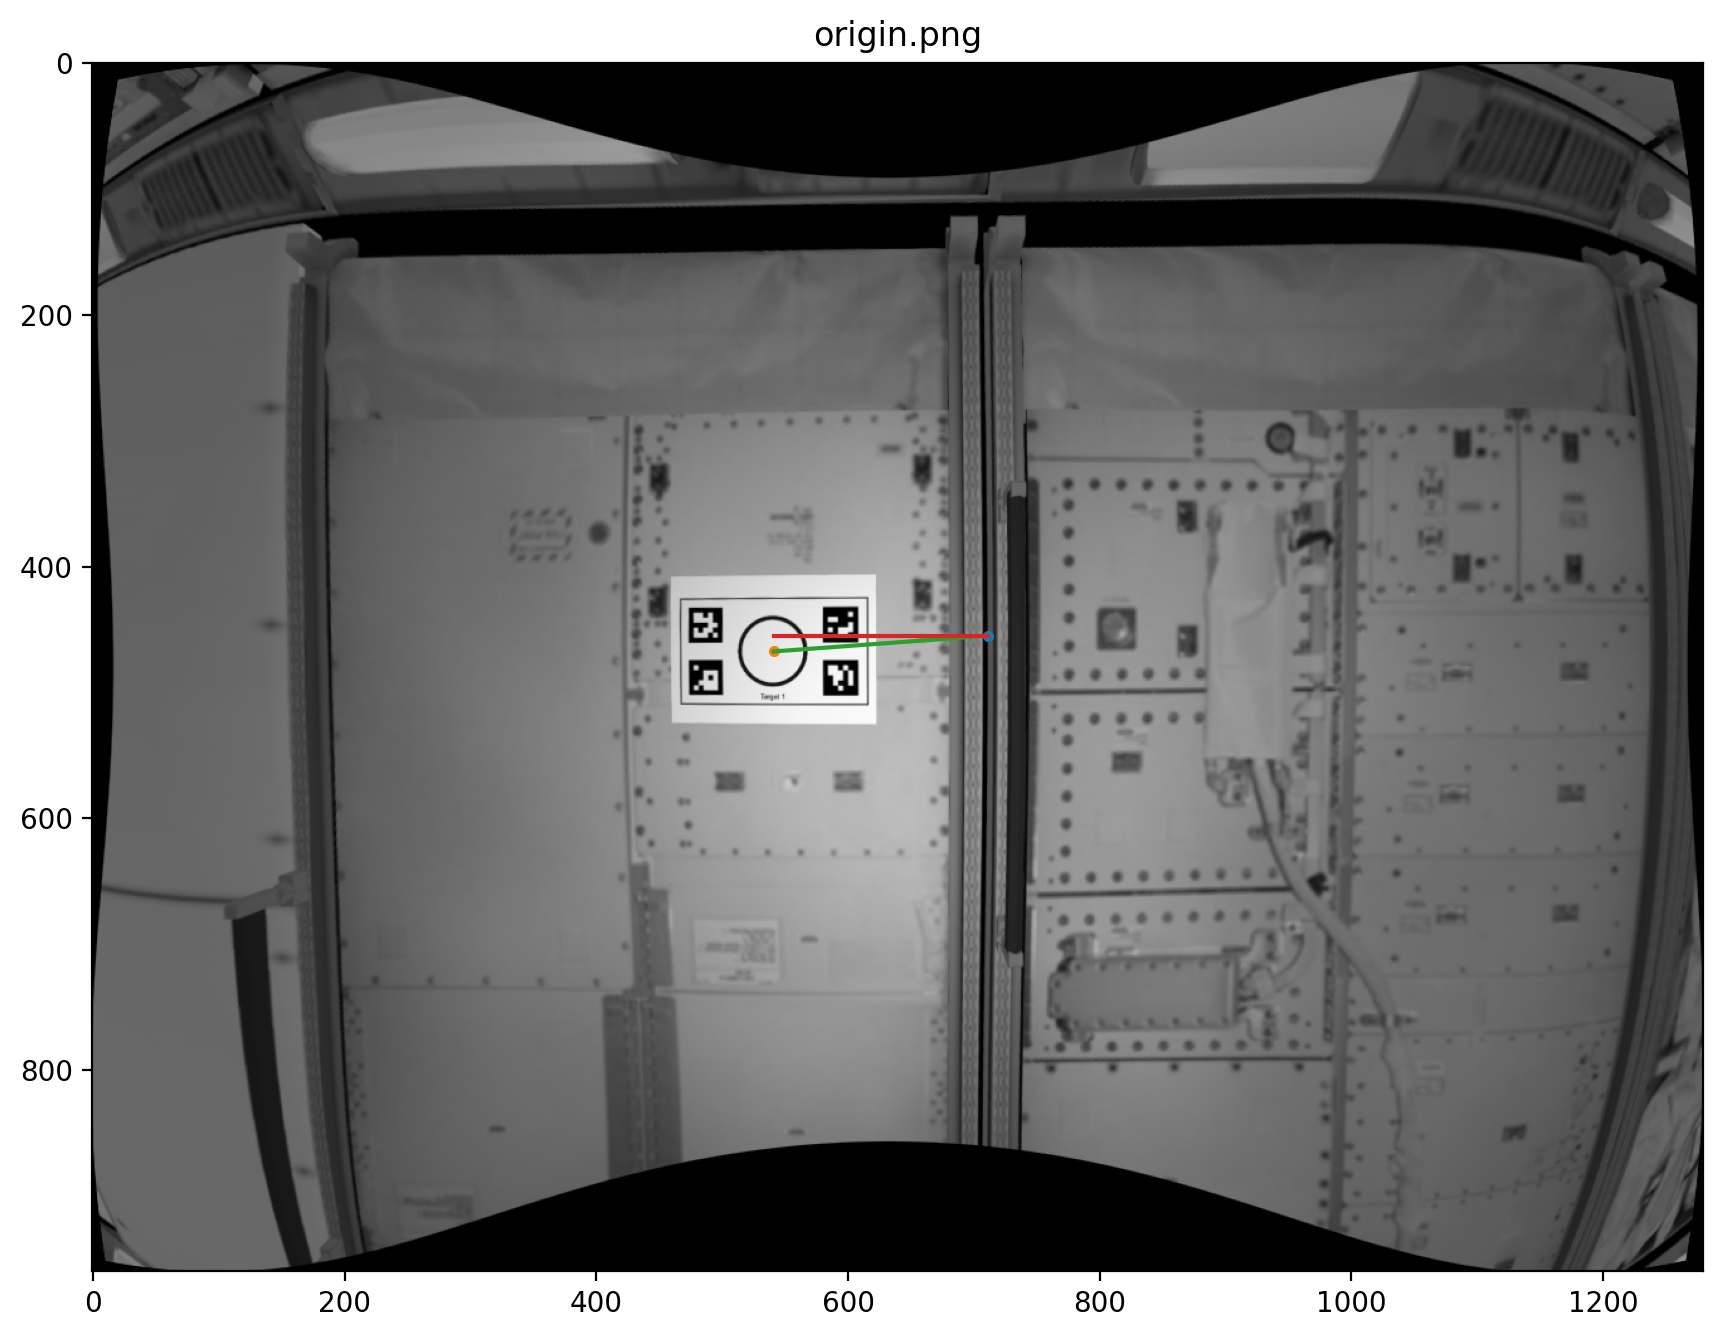

In [12]:
laser = (711, 455)

fig = plt.figure(figsize=(12, 8))
p = f"{path}/origin.png"
img = cv2.imread(p)
out = cv2.undistort(img, cam_mat, dist_coeffs, None, newcam_mat)
ax = fig.add_subplot()
ax.set_title("origin.png")
ax.imshow(out)
ax.plot(laser[0], laser[1], marker="o", markersize=3)
ax.plot(r_center[0], r_center[1], marker="o", markersize=3)
ax.plot([laser[0], r_center[0]], [laser[1], r_center[1]])
ax.plot(
    [laser[0], r_center[0]], [laser[1], laser[1]]
)  # may be we can just move in straigth line lol

We need smaller y. 

In [13]:
C = compute_C(origin, sy1, sy2)
distance_to_move = (laser[0] - r_center[0]) / C[0]

In [14]:
print(f"{-7.5 - distance_to_move:.6f}")

-7.811971


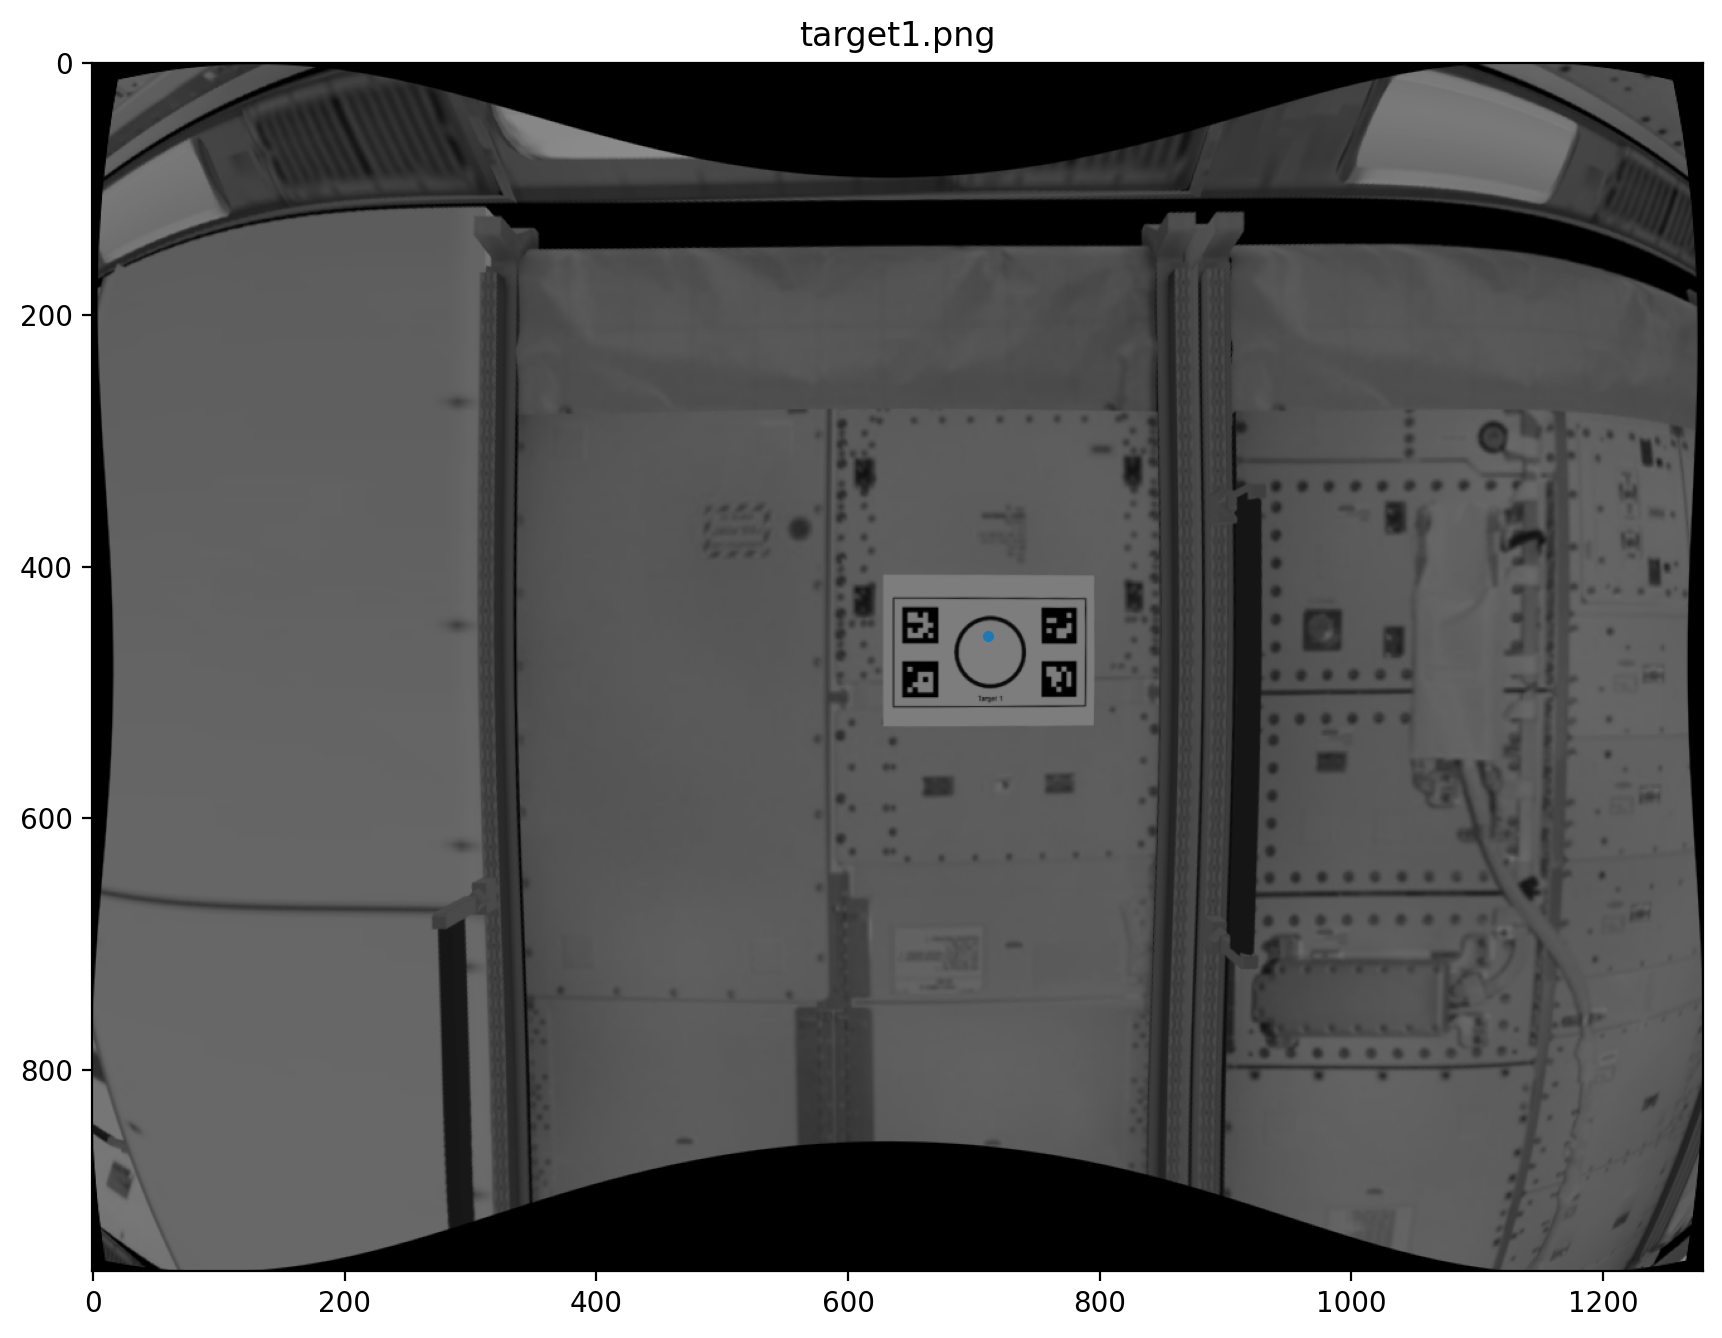

In [15]:
fig = plt.figure(figsize=(12, 8))
p = "./target1.png"
img = cv2.imread(p)
out = cv2.undistort(img, cam_mat, dist_coeffs, None, newcam_mat)
ax = fig.add_subplot()
ax.set_title("target1.png")
ax.imshow(out)
ax.plot(laser[0], laser[1], marker="o", markersize=3)

[660.63376999 574.09147499]
676 618


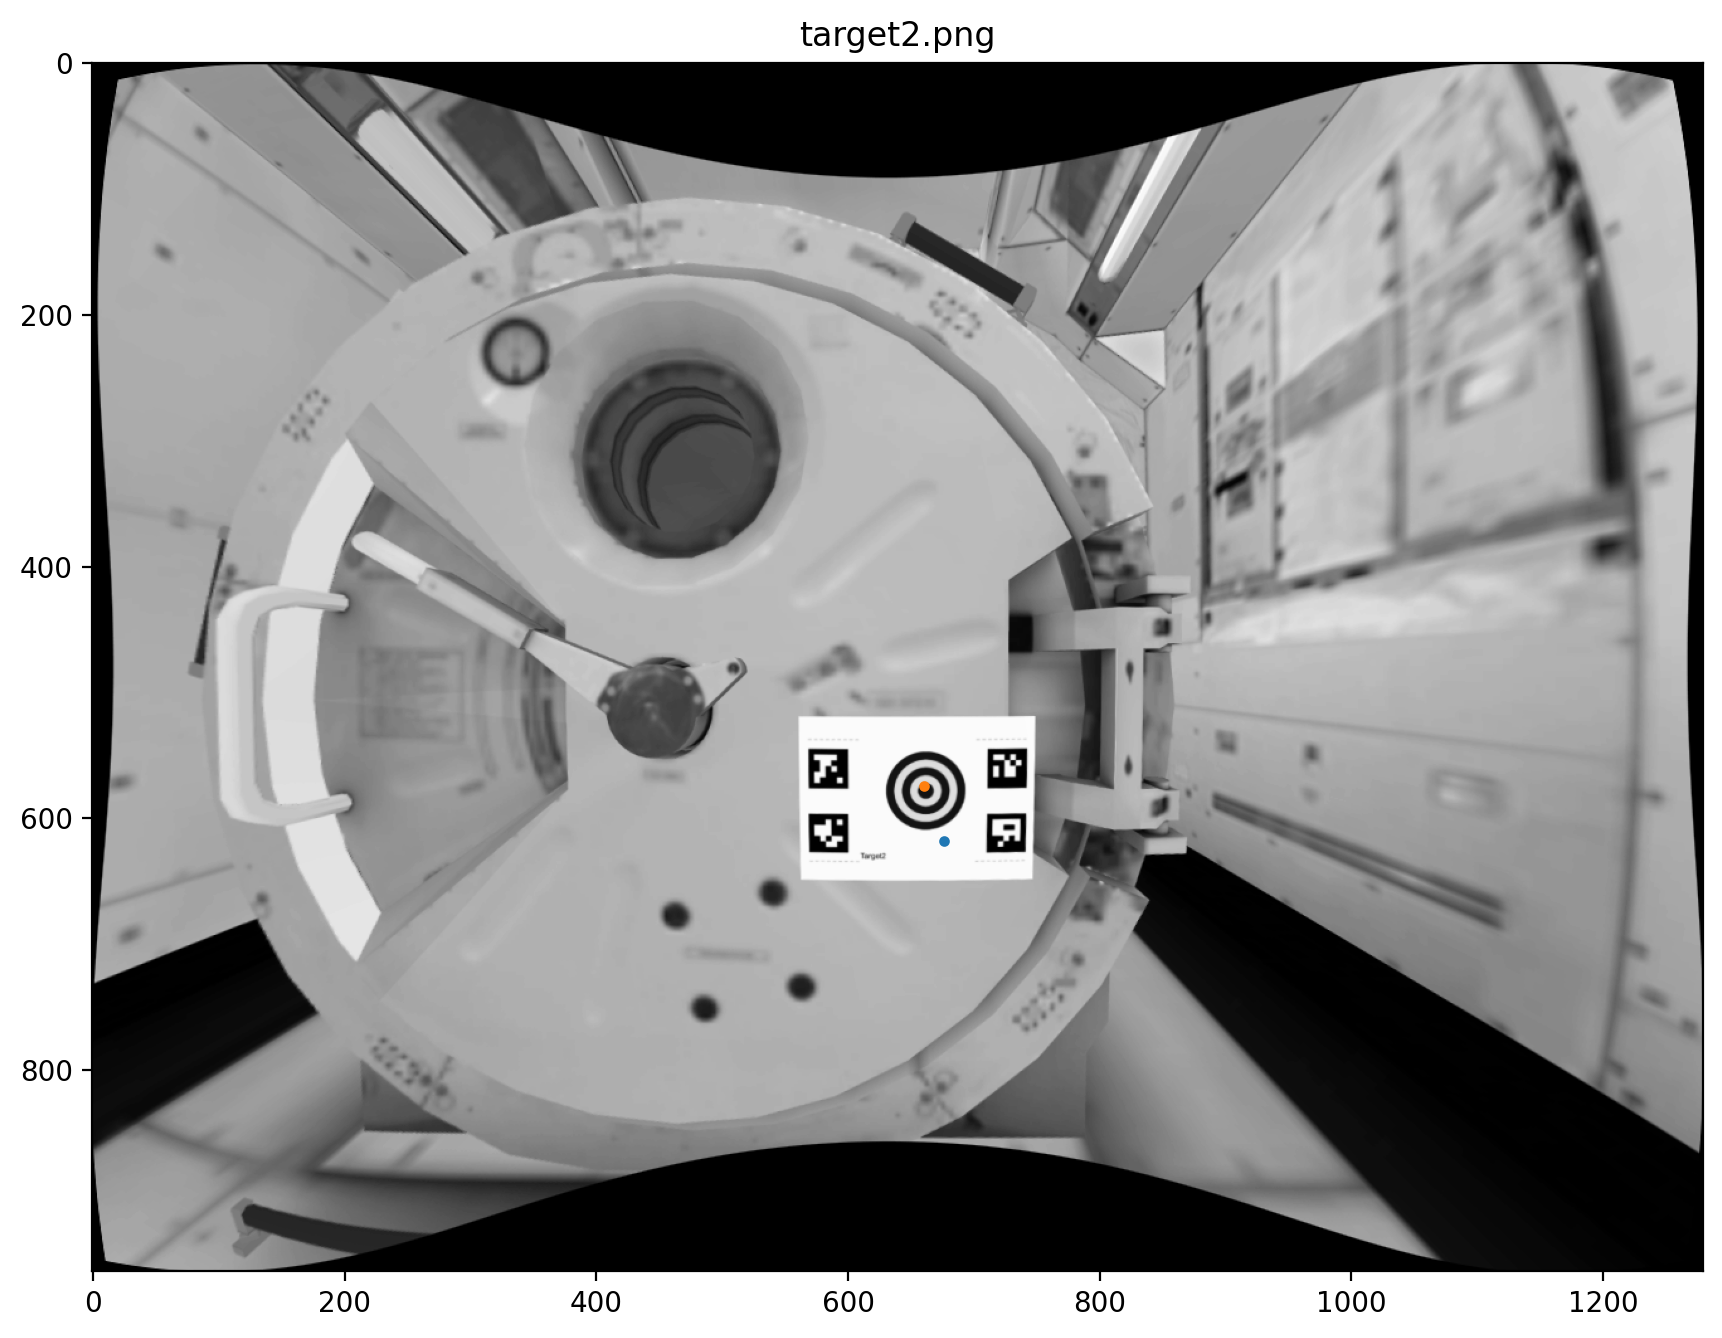

In [16]:
fig = plt.figure(figsize=(12, 8))
nc_img = cv2.imread("./target2.png", cv2.IMREAD_GRAYSCALE)
p = "./cropped_target2.png"
img = cv2.imread(p, cv2.IMREAD_GRAYSCALE)
# img = cv2.medianBlur(img, 5)
out = cv2.undistort(nc_img, cam_mat, dist_coeffs, None, newcam_mat)

circles = cv2.HoughCircles(
    img, cv2.HOUGH_GRADIENT, 1, 1300, param1=50, param2=30, minRadius=0, maxRadius=0
)

circles = np.uint16(np.around(circles))

ax = fig.add_subplot()
ax.set_title("target2.png")

for i in circles[0, :]:
    # draw the outer circle
    cv2.circle(img, (i[0], i[1]), i[2], (255, 0, 0), 2)
    """
    # draw the center of the circle
    cv2.circle(img,(i[0],i[1]),2,(255,0,0),1)
    """
    center = np.array([i[0] + 550, i[1] + 500], dtype=np.float64)
    ud_p = cv2.undistortPoints(center, cam_mat, dist_coeffs, None, newcam_mat)
    ud_p = ud_p[0][0]
    print(ud_p)
    print(i[0] + 550, i[1] + 500)
    ax.scatter(i[0] + 550, i[1] + 500, s=8)
    ax.scatter(ud_p[0], ud_p[1], s=8)

ax.imshow(out, cmap="gray")